In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import json
import os
import pathlib

In [2]:
# Setup SAM
from segment_anything import SamPredictor, sam_model_registry
HOME = str(pathlib.Path.home())
SAM_CHECKPOINT = f"{HOME}/data/sam/sam_vit_h_4b8939.pth"
SAM_MODEL = sam_model_registry["default"](checkpoint=SAM_CHECKPOINT)
PREDICTOR = SamPredictor(SAM_MODEL)

/home/nick/projectaria_tools_python_env/lib/python3.8/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [4]:
class ImageExtractorIterator:
    def __init__(self, image_extractor_path: str, camera_list_file = "CameraList.json", cameras = [], image_filename = "BGRImage.jpg"):
        self.image_extractor_path = image_extractor_path
        self.camera_list_path = os.path.join(image_extractor_path, camera_list_file)
        self.cameras = cameras
        self.camera_id = 0
        self.image_id = 0
        self.image_filename = image_filename
        
        print(f"Reading camera list file: {self.camera_list_path}")
        with open(self.camera_list_path, 'r') as f:
            camera_list_data = json.load(f)
            self.images_filename = camera_list_data["ImagesFilename"]
            if not self.cameras:
                self.cameras = camera_list_data["Cameras"]
            else:
                for camera in self.cameras:
                    assert camera in camera_list_data["Cameras"], f"camera {camera} not found"

        self._get_current_images()

    def _get_current_images(self):
        self.current_images_list = []
        images_list_path = os.path.join(image_extractor_path, self.cameras[self.camera_id], f"{self.images_filename}.json")
        with open(images_list_path, 'r') as f:
            images_data = json.load(f)
            for image in images_data["Images"]:
                image_container_path = os.path.join(image_extractor_path, self.cameras[self.camera_id], f"{image}")
                assert os.path.exists(image_container_path), f"image container does not exist: {image_path}"
                image_path = os.path.join(image_container_path, self.image_filename)
                if os.path.exists(image_path):
                    self.current_images_list.append(image_path)
            
    def next(self):
        image_id = self.image_id
        if image_id > len(self.current_images_list) - 1:
            self.camera_id += 1
            self.image_id = 0
            if self.camera_id > len(self.cameras) - 1:
                return None
            self._get_current_images()    
        self.image_id += 1
        return self.current_images_list[image_id]

    def skip_n(self, n: int):
        image_path = ""
        for i in range(n):
            image_path = self.next()
        return image_path    
        
        

In [11]:
def use_image():    
    while (True):
        # print("label this image? (y/n):")
        user_input = input("label this image? (y/n):").lower()
        if user_input == 'y':
            return True
        elif user_input == 'n':
            return False
        else:
            print("Invalid input. Please enter 'y' or 'n'.")

def get_clicked_points(image_path, downsize_factor = 0.3):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    h = image.shape[0]
    w = image.shape[1]
    img = cv2.resize(image, (int(w *downsize_factor) , int(h *downsize_factor)))

    # Define a function to handle mouse click event

    def onclick(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            nonlocal current_clicked_point  # Use nonlocal to modify the variable
            current_clicked_point = (x / downsize_factor, y / downsize_factor)

    # Initialize clicked_point variable
    current_clicked_point = None
    clicked_points = []
    labels = []
    
    # Create a window and display the image
    cv2.namedWindow("Select a point on the image")
    cv2.imshow("Select a point on the image", img)

    # Connect the function to the mouse click event
    cv2.setMouseCallback("Select a point on the image", onclick)

    # Wait for the user to click
    print("select a point on the image and then press:\n" 
          "'y' to mark as positive, "
          "'n' to mark as negative, "
          "'d' to remove last, "
          "and 'enter' to complete adding points")
    while True:
        k = cv2.waitKey(0)
        if k == 121:
            print("adding positive point prompt")    
            center = (int(current_clicked_point[0] * downsize_factor), int(current_clicked_point[1] * downsize_factor))
            cv2.circle(img, center, 5, (0,255,0), 2)
            cv2.imshow("Select a point on the image", img)
            clicked_points.append(current_clicked_point)
            labels.append(1)
        elif k == 110:
            print("adding negative point prompt")
            center = (int(current_clicked_point[0] * downsize_factor), int(current_clicked_point[1] * downsize_factor))
            cv2.circle(img, center, 5, (0,0,255), 2)
            cv2.imshow("Select a point on the image", img)
            clicked_points.append(current_clicked_point)
            labels.append(0)
        elif k == 13:
            print("done selecting points")
            break
        elif k == 100:
            print("removing last point if available")
            if clicked_points:
                center = (int(clicked_points[-1][0] * downsize_factor), int(clicked_points[-1][1] * downsize_factor))
                cv2.circle(img, center, 5, (0,0,0), 2)
                cv2.imshow("Select a point on the image", img)
                clicked_points = clicked_points[:-1]
                labels = labels[:-1]
        else:
            print("invalid key, options: y, n, d, enter")
        
        
    cv2.destroyAllWindows()
    return clicked_points, labels

select a point on the image and then press:
'y' to mark as positive, 'n' to mark as negative, 'd' to remove last, and 'enter' to complete adding points
adding positive point prompt
adding positive point prompt
adding positive point prompt
adding negative point prompt
adding negative point prompt
done selecting points
predicting masks


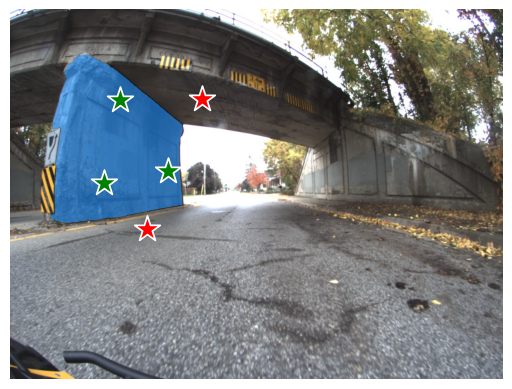

In [35]:
from IPython.display import display, clear_output

image_extractor_path = "/home/nick/d/results/image_extractor/"
selected_cameras = ["F1_link"]
image_iter = ImageExtractorIterator(
    image_extractor_path = image_extractor_path, 
    camera_list_file = "CameraList.json", 
    cameras = selected_cameras
) 
skip_first_n_imgs = 10
image_iter.skip_n(skip_first_n_imgs)

while True:
    clear_output()
    image_path = image_iter.next()
    if image_path is None:
        break
            
    image_bgr = cv2.imread(image_path)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    if not use_image():
        continue        

    clear_output()
    coords, labels = get_clicked_points(image_path)
    # convert to numpy
    num_points = len(coords)
    input_point = np.zeros((num_points, 2))
    input_label = np.array(labels)
    for i in range(num_points):
        input_point[i][0] = coords[i][0]
        input_point[i][1] = coords[i][1]
    
    if not coords:
        print("No coordinates selected, skipping to next image")
        continue

    print("predicting masks")
    PREDICTOR.set_image(image)
    mask, score, logit = PREDICTOR.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )
    
    plt.imshow(image)
    show_points(input_point, input_label, plt.gca())
    show_mask(mask, plt.gca())
    plt.axis('off')
    plt.show() 
    
    break

In [37]:
# Create 3 images:
img_h = mask.shape[1]
img_w = mask.shape[2]
bgr_mask = np.zeros((img_h, img_w))
bgr_mask_viz = np.zeros((img_h, img_w))
bgr_mask_overlay = image_bgr.copy()
save_path = "/home/nick/Downloads"
for j in range(mask.shape[1]):
    for k in range(mask.shape[2]):
        if mask[0][j][k]:
            bgr_mask_overlay[j][k] = (0,0,255)
            bgr_mask_viz[j][k] = 255/2
            bgr_mask[j][k] = 1

bgr_mask_save_path = os.path.join(save_path, "BGRMask.jpg")
bgr_mask_viz_save_path = os.path.join(save_path, "BGRMaskViz.jpg")
bgr_mask_overlay_save_path = os.path.join(save_path, "BGRMaskOverlay.jpg")
cv2.imwrite(bgr_mask_save_path, bgr_mask)
cv2.imwrite(bgr_mask_viz_save_path, bgr_mask_viz)
cv2.imwrite(bgr_mask_overlay_save_path, bgr_mask_overlay)

True